<a href="https://colab.research.google.com/github/xeron56/landcover-analysis-of-costal-area-of-bangladesh/blob/main/%20landcover-analysis-of-costal-area-of-bangladesh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
!pip install rasterio
!pip install geopandas


     |████████████████████████████████| 19.3 MB 1.2 MB/s 
     |████████████████████████████████| 1.0 MB 5.1 MB/s 
     |████████████████████████████████| 15.4 MB 39 kB/s 
     |████████████████████████████████| 6.3 MB 24.5 MB/s 


In [ ]:
import rasterio
from rasterio.mask import mask
import geopandas as gpd
import numpy as np
from shapely.geometry import mapping
import os

In [ ]:
img_dir = '/gdrive/MyDrive/thesis/dataset/merge/'
# check to see if the dir it exists, if not, create it
if not os.path.exists(img_dir):
    os.makedirs(img_dir)

# filepath for image we're writing out
img_fp = img_dir + '2020.tif'

In [ ]:
full_dataset = rasterio.open(img_fp)
img_rows, img_cols = full_dataset.shape
img_bands = full_dataset.count
print(full_dataset.shape) # dimensions
print(full_dataset.count) # bands

(10811, 11956)
7


(3, 10811, 11956)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


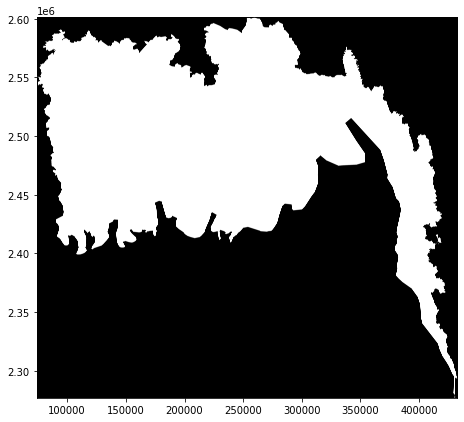

In [ ]:
import matplotlib.pyplot as plt
from rasterio.plot import show

clipped_img = full_dataset.read([4,3,2])
print(clipped_img.shape)
fig, ax = plt.subplots(figsize=(10,7))
show(clipped_img[:, :, :], ax=ax, transform=full_dataset.transform) # add the transform arg to get it in lat long coords

In [ ]:
full_dataset.crs

CRS.from_epsg(32646)

In [ ]:
shapefile = gpd.read_file('/gdrive/MyDrive/thesis/dataset/s1/1.shp')
shapefile.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [ ]:
shapefile = shapefile.to_crs({'init': 'epsg:32646'})

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [ ]:
shapefile.crs

<Projected CRS: EPSG:32646>
Name: WGS 84 / UTM zone 46N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 90°E and 96°E, northern hemisphere between equator and 84°N, onshore and offshore. Bangladesh. Bhutan. China. Indonesia. Mongolia. Myanmar (Burma). Russian Federation.
- bounds: (90.0, 0.0, 96.0, 84.0)
Coordinate Operation:
- name: UTM zone 46N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [ ]:
len(shapefile)

385

In [ ]:
# this generates a list of shapely geometries
geoms = shapefile.geometry.values 

# let's grab a single shapely geometry to check
geometry = geoms[0] 
print(type(geometry))
print(geometry)

# transform to GeoJSON format
from shapely.geometry import mapping
feature = [mapping(geometry)] # can also do this using polygon.__geo_interface__
print(type(feature))
print(feature)

<class 'shapely.geometry.point.Point'>
POINT (378069.991707261 2470776.953092568)
<class 'list'>
[{'type': 'Point', 'coordinates': (378069.99170726095, 2470776.9530925676)}]


In [ ]:
out_image, out_transform = mask(full_dataset, feature, crop=True)
out_image.shape

(7, 1, 1)

In [ ]:
full_dataset.close()

In [ ]:
X = np.array([], dtype=np.int8).reshape(0,7) # pixels for training
y = np.array([], dtype=np.string_) # labels for training

# extract the raster values within the polygon 
with rasterio.open(img_fp) as src:
    band_count = src.count
    for index, geom in enumerate(geoms):
        feature = [mapping(geom)]

        # the mask function returns an array of the raster pixels within this feature
        out_image, out_transform = mask(src, feature, crop=True) 
        # eliminate all the pixels with 0 values for all 7 bands - AKA not actually part of the shapefile
        out_image_trimmed = out_image[:,~np.all(out_image == 0, axis=0)]
        # eliminate all the pixels with 255 values for all 7 bands - AKA not actually part of the shapefile
        out_image_trimmed = out_image_trimmed[:,~np.all(out_image_trimmed == 255, axis=0)]
        # reshape the array to [pixel count, bands]
        out_image_reshaped = out_image_trimmed.reshape(-1, band_count)
        # append the labels to the y array
        y = np.append(y,[shapefile["classname"][index]] * out_image_reshaped.shape[0]) 
        # stack the pizels onto the pixel array
        X = np.vstack((X,out_image_reshaped))        

In [ ]:
# What are our classification labels?
labels = np.unique(shapefile["classname"])
print('The training data include {n} classes: {classes}\n'.format(n=labels.size, 
                                                                classes=labels))

# We will need a "X" matrix containing our features, and a "y" array containing our labels
print('Our X matrix is sized: {sz}'.format(sz=X.shape))
print('Our y array is sized: {sz}'.format(sz=y.shape))

The training data include 5 classes: ['agriculture' 'built-up' 'vegetation' 'water' 'wet-land']

Our X matrix is sized: (385, 7)
Our y array is sized: (385,)


Text(0.5, 1.0, 'Band Intensities Higher Ref Subset')

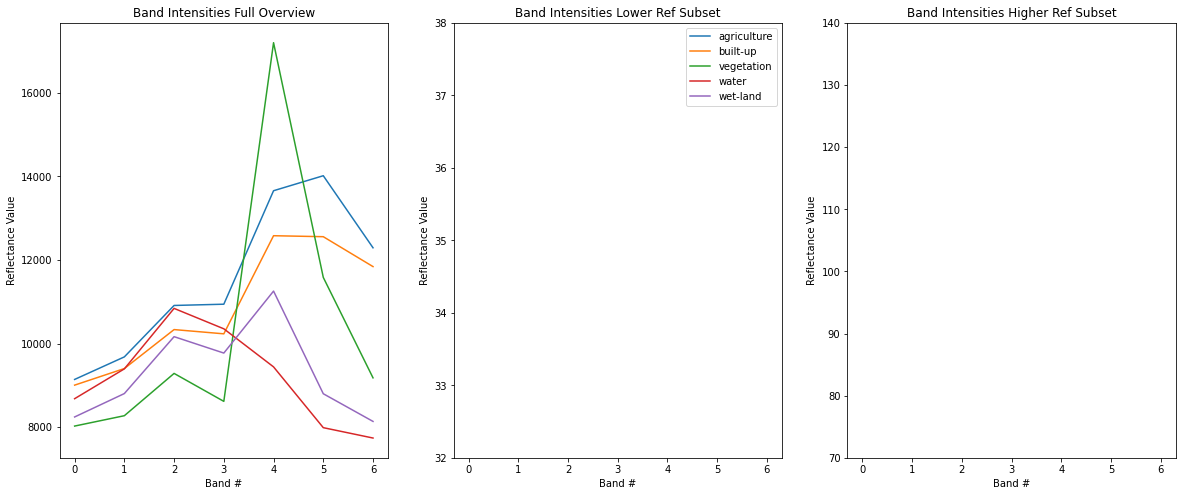

In [ ]:
fig, ax = plt.subplots(1,3, figsize=[20,8])

# numbers 1-4
band_count = np.arange(0,7)

classes = np.unique(y)
for class_type in classes:
    band_intensity = np.mean(X[y==class_type, :], axis=0)
    ax[0].plot(band_count, band_intensity, label=class_type)
    ax[1].plot(band_count, band_intensity, label=class_type)
    ax[2].plot(band_count, band_intensity, label=class_type)
# plot them as lines

# Add some axis labels
ax[0].set_xlabel('Band #')
ax[0].set_ylabel('Reflectance Value')
ax[1].set_ylabel('Reflectance Value')
ax[1].set_xlabel('Band #')
ax[2].set_ylabel('Reflectance Value')
ax[2].set_xlabel('Band #')
#ax[0].set_ylim(32,38)
ax[1].set_ylim(32,38)
ax[2].set_ylim(70,140)
#ax.set
ax[1].legend(loc="upper right")
# Add a title
ax[0].set_title('Band Intensities Full Overview')
ax[1].set_title('Band Intensities Lower Ref Subset')
ax[2].set_title('Band Intensities Higher Ref Subset')


# Assign the code class value

In [ ]:
def str_class_to_int(class_array):
    class_array[class_array == 'water'] = 0
    class_array[class_array == 'built-up'] = 1
    class_array[class_array == 'vegetation'] = 2
    class_array[class_array == 'agriculture'] = 3
    class_array[class_array == 'wet-land'] = 4
    return(class_array.astype(int))

## Training the Classifier



In [ ]:
# xgboost
import pandas as pd
import numpy as np
import xgboost
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler


xgb_clf = xgboost.XGBClassifier()
xgb_clf.fit(X, y)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

## Predicting on the image



In [ ]:
from rasterio.plot import show
from rasterio.plot import show_hist
from rasterio.windows import Window
from rasterio.plot import reshape_as_raster, reshape_as_image

In [ ]:
with rasterio.open(img_fp) as src:
    # may need to reduce this image size if your kernel crashes, takes a lot of memory
    img = src.read()[:, 1000:6000, 2500:14000]

# Take our full image and reshape into long 2d array (nrow * ncol, nband) for classification
print(img.shape)
reshaped_img = reshape_as_image(img)
print(reshaped_img.shape)

(7, 5000, 9456)
(5000, 9456, 7)


In [ ]:
#class_prediction = gnb.predict(reshaped_img.reshape(-1, 7))
predictions_xg = xgb_clf.predict(reshaped_img.reshape(-1,7))

# Reshape our classification map back into a 2D matrix so we can visualize it
#class_prediction = class_prediction.reshape(reshaped_img[:, :, 0].shape)
predictions_xg = predictions_xg.reshape(reshaped_img[:, :, 0].shape)

# Because our shapefile came with the labels as strings we want to convert them to a numpy array with ints using the helper function we made earlier.





NameError: ignored

In [ ]:
predictions_xg = str_class_to_int(predictions_xg)

In [ ]:
def color_stretch(image, index):
    colors = image[:, :, index].astype(np.float64)
    for b in range(colors.shape[2]):
        colors[:, :, b] = rasterio.plot.adjust_band(colors[:, :, b])
    return colors
    
# find the highest pixel value in the prediction image
n = int(np.max(predictions_xg))

# next setup a colormap for our map
colors = dict((
    (0, (48, 156, 214, 255)),   # Blue - Water
    (1, (255,255, 0, 255)),      # yellow - built-up
    (2, (96, 19, 134, 255)),    # Purple - vegetation
    (3, (244, 164, 96, 255)),   # Tan - agriculture
    (4, (206, 224, 196, 255)),  # Lime - wet-land
    
))

# Put 0 - 255 as float 0 - 1
for k in colors:
    v = colors[k]
    _v = [_v / 255.0 for _v in v]
    colors[k] = _v
    
index_colors = [colors[key] if key in colors else 
                (255, 255, 255, 0) for key in range(0, n+1)]

cmap = plt.matplotlib.colors.ListedColormap(index_colors, 'Classification', n+1)

classified image

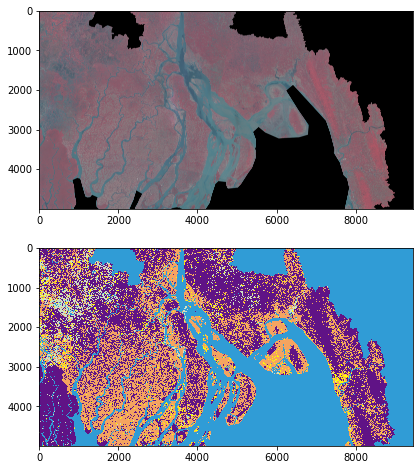

In [ ]:
# Now show the classified map next to the RGB image!

fig, axs = plt.subplots(2,1,figsize=(20,8))

img_stretched = color_stretch(reshaped_img, [4, 3, 2])
axs[0].imshow(img_stretched)

axs[1].imshow(predictions_xg, cmap=cmap, interpolation='none')

fig.show()
plt.show()

In [ ]:
y = predictions_xg.astype(np.int32) 

SalidaR = rasterio.open(img_dir + 'landcover_2020.tif','w',
                   driver='Gtiff',
                   width = 9456,
                   height = 5000,
                   count=1,
                   crs = full_dataset.crs,  
                   transform = full_dataset.transform, 
                   dtype='int32'
                   )
SalidaR.write(y,1)
SalidaR.close()

print("Raster image succesfully created!")

Raster image succesfully created!
